# Lamda data

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro import param
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from cosmos.models import Tracker
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

### Results

Tracker v1.1.4prox

In [3]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

# calculate signal-to-noise ratio
heights = ["3000"]
snr = []
for h in heights:
    weights = rv.log_prob(ij_pixel).exp()
    signal = (weights ** 2 * float(h)).sum()
    noise = ((signal+background) * gain).sqrt()
    snr.append(float(signal / noise))

In [4]:
pi_z = "15"
params_last = {}
predictions = {}
labels = {}

names = ["01", "03", "15", "50", "85", "99"]

In [7]:
snr = []

for name in names:
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.4three/S1/K2/control/lr0.005/bs5".format(name)
    model = Tracker(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

In [8]:
for name in names:
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.4three/S1/K2/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_data, "runs/tracker/v1.1.4three/S1/K2/control/lr0.005/bs5/predictions.npy"))
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))

In [10]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_z_0", "pi_j_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13["pi_naive"] = scores_v1p13.apply(lambda x: (x.TP + x.FP)/(15*500), axis=1)
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_z_1,pi_j_1,offset_samples_0,offset_weights_0,MCC,Recall,Precision,FN,TP,TN,FP,pi_naive
01,29900.0,14382437.0,0.5,7.044966,0.155398,0.008462,90.000008,1.0,0.999493,1.000000,0.999143,0.0,1166.0,6333.0,1.0,0.155600
03,29900.0,14395548.0,0.5,7.048306,0.155793,0.025148,90.000008,1.0,0.996964,1.000000,0.994881,0.0,1166.0,6328.0,6.0,0.156267
15,29900.0,14440596.0,0.5,7.143784,0.160552,0.126085,90.000008,1.0,0.978198,0.999142,0.964404,1.0,1165.0,6291.0,43.0,0.161067
50,29900.0,14576115.0,0.5,7.375396,0.165173,0.413990,90.000008,1.0,0.943452,0.989708,0.916600,12.0,1154.0,6229.0,105.0,0.167867
85,29900.0,14677392.0,0.5,7.579234,0.163396,0.706607,90.000008,1.0,0.919844,0.956261,0.909462,51.0,1115.0,6223.0,111.0,0.163467
99,29900.0,14732660.0,0.5,7.683702,0.148998,0.822052,90.000008,1.0,0.905056,0.913379,0.926087,101.0,1065.0,6249.0,85.0,0.153333


torch.Size([101, 14, 14])


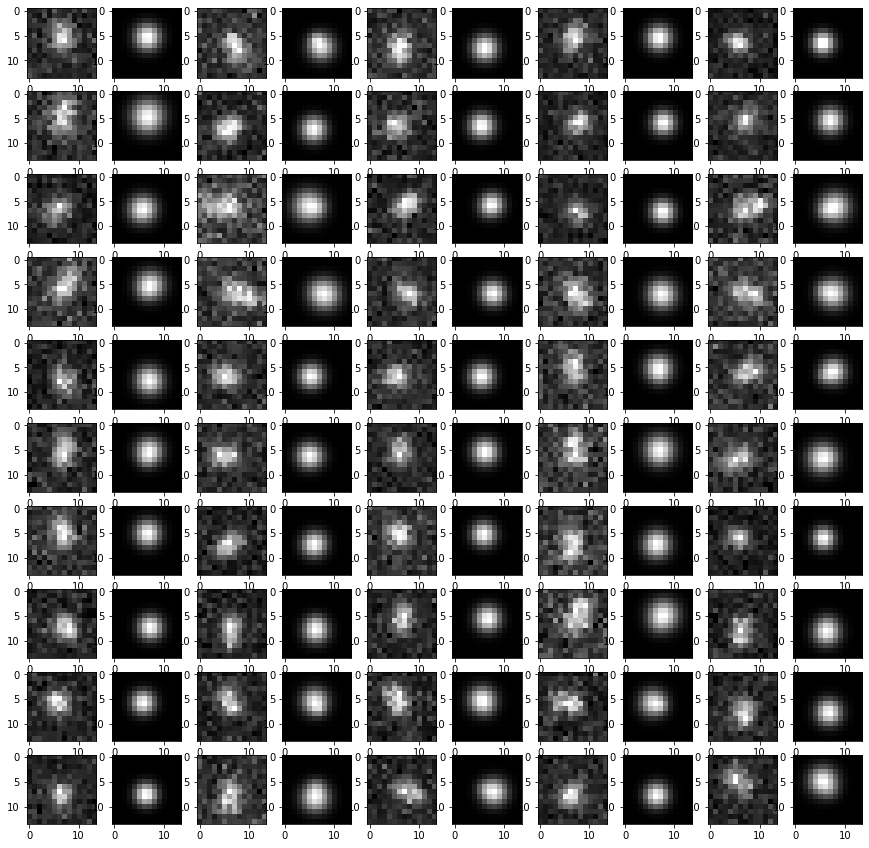

In [15]:
# spots missed by cosmos
mask = ((model.data.labels["z"] & ~model.predictions["z"]))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(50, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]],
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.imshow(ideal.numpy(), cmap="gray")
plt.show()

In [21]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
scores_v1p13["SNR"] = snr
scores_v1p13["pi_naive"] = scores_v1p13.apply(lambda x: (x.TP + x.FP)/(15*500), axis=1)
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_1,lamda_1,offset_samples_0,offset_weights_0,MCC,Recall,Precision,FN,TP,TN,FP,SNR,pi_naive
01,29800.0,14390221.0,0.5,7.044241,0.161282,0.008173,89.500015,1.0,0.994963,1.000000,0.991518,0.0,1169.0,6321.0,10.0,0.01,0.157200
03,29800.0,14403316.0,0.5,7.039243,0.164633,0.024720,89.500015,1.0,0.988998,1.000000,0.981528,0.0,1169.0,6309.0,22.0,0.03,0.158800
15,19800.0,14512133.0,0.5,7.282000,0.170712,0.127169,89.500015,1.0,0.956265,1.000000,0.927778,0.0,1169.0,6240.0,91.0,0.15,0.168000
50,29800.0,14670762.0,0.5,7.247830,0.172116,0.454612,89.500015,1.0,0.897192,0.977759,0.854260,26.0,1143.0,6136.0,195.0,0.50,0.178400
85,29800.0,14809739.0,0.5,7.228729,0.169646,0.773886,89.500015,1.0,0.874864,0.970060,0.826531,35.0,1134.0,6093.0,238.0,0.85,0.182933
99,29800.0,14866692.0,0.5,7.266937,0.173179,0.900357,89.500015,1.0,0.861228,0.962361,0.812274,44.0,1125.0,6071.0,260.0,0.99,0.184667


In [19]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data/lamda_data/lamda{}.mat".format(name))

In [20]:
scores_sp = pd.DataFrame(data={
    "spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "TN": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[0] for name in names],
    "FP": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[1] for name in names],
    "FN": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[2] for name in names],
    "TP": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[3] for name in names],
                    },
             index=names)
scores_sp["pi_naive"] = scores_sp.apply(lambda x: (x.TP + x.FP)/(15*500), axis=1)
scores_sp

,spMCC,spRecall,spPrecision,TN,FP,FN,TP,pi_naive
01,0.987974,0.998289,0.981497,6309,22,2,1167,0.158533
03,0.978047,0.994012,0.969141,6294,37,7,1162,0.159867
15,0.938699,0.976048,0.921648,6234,97,28,1141,0.165067
50,0.857590,0.932421,0.832061,6111,220,79,1090,0.174667
85,0.792527,0.882806,0.774194,6030,301,137,1032,0.177733
99,0.758779,0.855432,0.745712,5990,341,169,1000,0.178800


In [14]:
snr = [float(name)/100 for name in names]

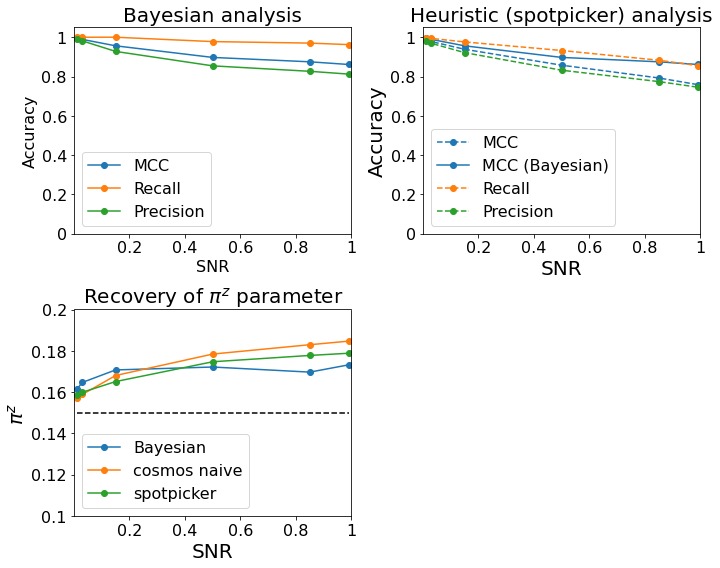

In [28]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="Bayesian")
plt.plot(snr, scores_v1p13["pi_naive"], "o-", label="cosmos naive")
plt.plot(snr, scores_sp["pi_naive"], "o-", label="spotpicker")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0.1,0.2)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
#plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

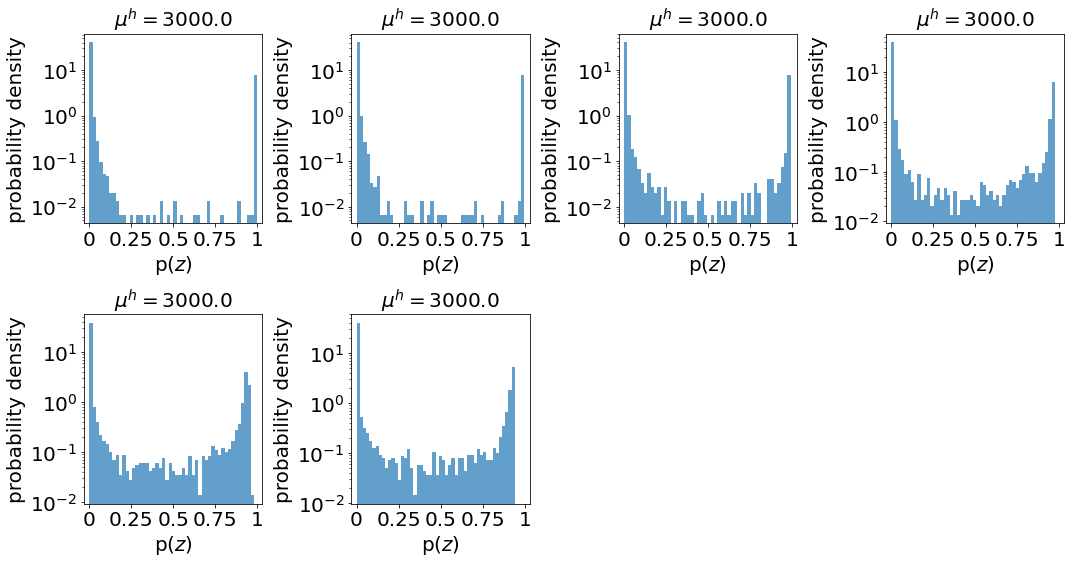

In [12]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[name]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

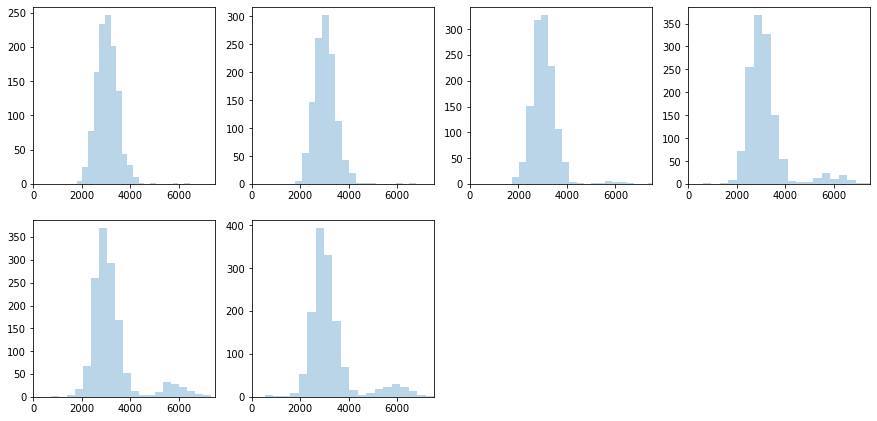

In [13]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/h_loc").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 7500)
plt.show()

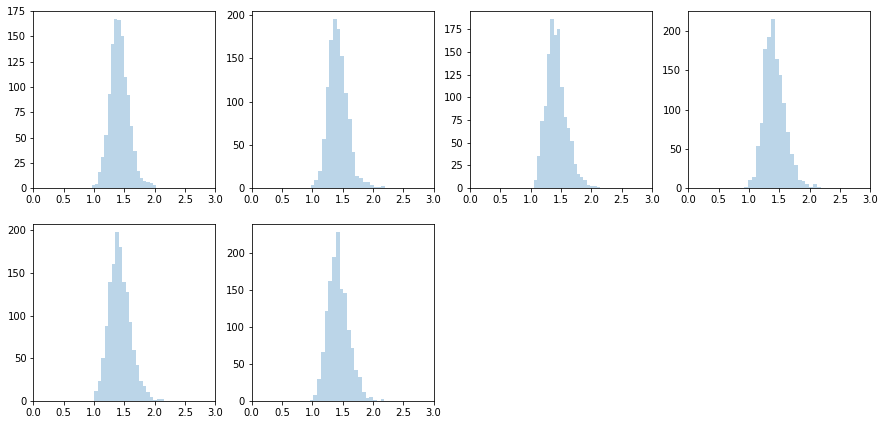

In [14]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/w_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 3)
plt.show()

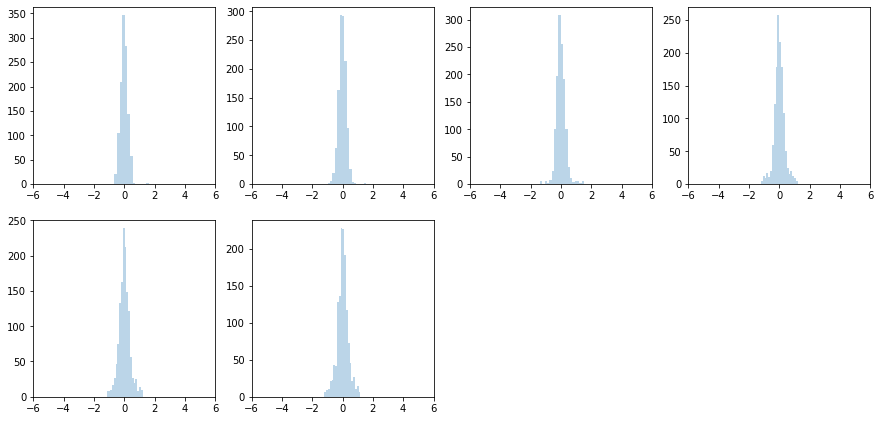

In [15]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/x_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(-6, 6)
plt.show()

In [5]:
# load cosmos results
name = "15"
path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.4noise/S1/nocontrol/lr0.005/bs5".format(name)
model = Tracker(S=1)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([5824, 14, 14])


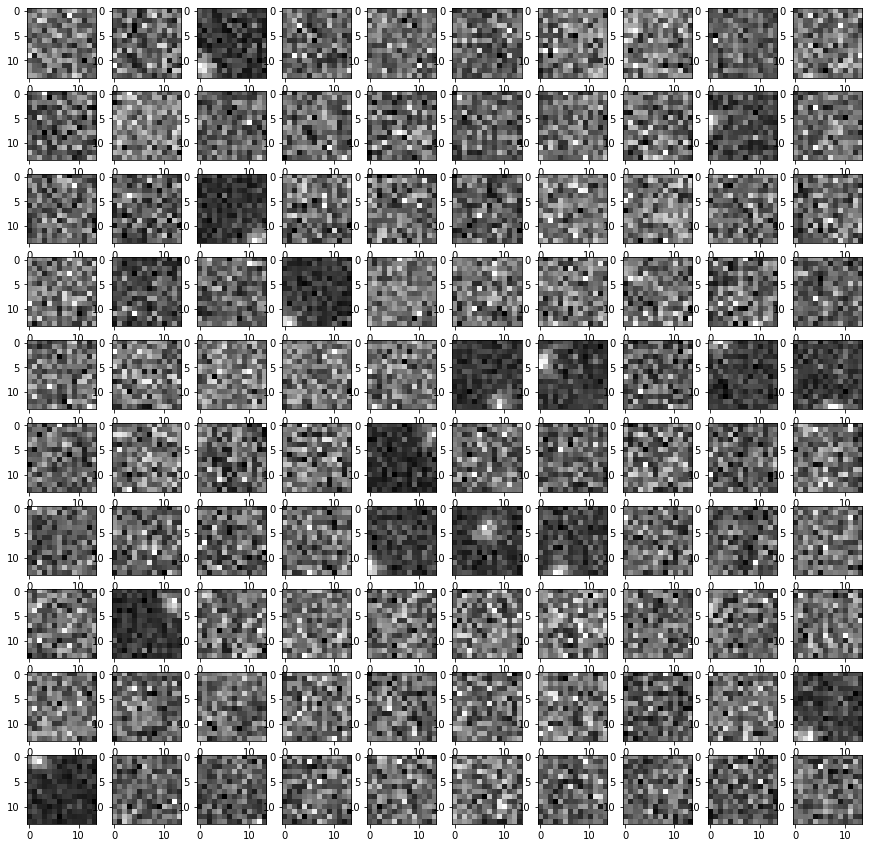

In [7]:
# spots detected by spotpicker and missed by cosmos
#mask = ((~model.data.labels["z"] & (model.z_marginal.numpy() > 0.5)))
mask = ((~model.data.labels["z"] & (model.predictions["z_prob"] > 0.5)))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([155, 14, 14])


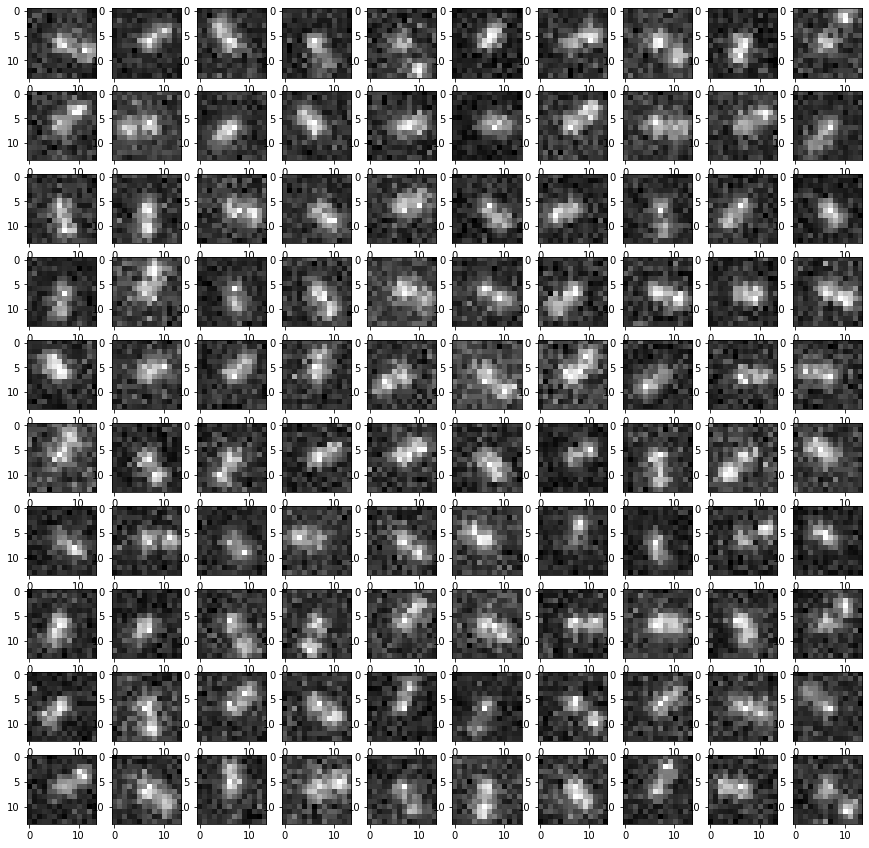

In [17]:
# spots detected by cosmos and missed by spotpicker
mask = ((model.data.labels["z"] & model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([30, 14, 14])


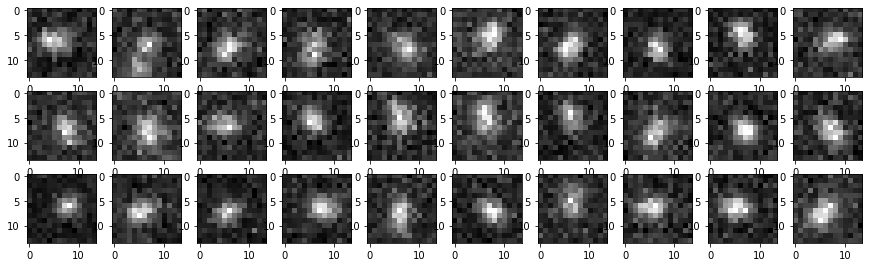

In [18]:
# spots detected by spotpicker and missed by cosmos
mask = ((model.data.labels["z"] & ~model.predictions["z"] & sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([14, 14, 14])


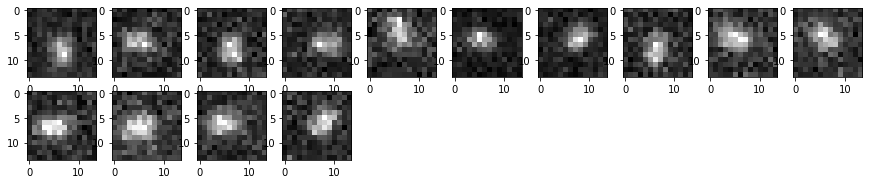

In [19]:
# spots missed by both cosmos and spotpicker
mask = ((model.data.labels["z"] & ~model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

In [4]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
torch.tensor(1.)

tensor(1.)

In [17]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
name = "15"
path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
model = Tracker(S=1)
model.load(path_data, False, "cuda")

In [13]:
x = torch.tensor([0.7, 0.2, 0.1]).reshape(3,1)

In [9]:
x.log()

tensor([-0.3567, -1.6094, -2.3026])

In [10]:
from torch.distributions.utils import probs_to_logits, logits_to_probs
probs_to_logits(x)

tensor([-0.3567, -1.6094, -2.3026])

In [15]:
x[torch.tensor([[0, 0], [2, 1]])].shape

torch.Size([2, 2, 1])

In [26]:
probs_to_logits(torch.ones(3)/3)

tensor([-1.0986, -1.0986, -1.0986])

In [21]:
model.data[torch.tensor([[0, 0], [2, 1]])].shape

torch.Size([2, 2, 500, 14, 14])

In [5]:
name = "FL_5555_6684_1p3OD"
path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
#path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

[autoreload of cosmos.models failed: Traceback (most recent call last):
  File "/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ordabayev/anaconda3/envs/dev/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ordabayev/anaconda3/envs/dev/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ordabayev/repos/cosmos/cosmos/models/__init__.py", line 19, in <module>
    Tracker.name: Tracker,
AttributeError: 

In [34]:
from pytorch_memlab import LineProfiler

with LineProfiler(
        model.load,
        model.settings,
        model.spot_parameters,
        model.spot_model,
        model.spot_guide,
        model.data_loc) as prof:
    model = Tracker(S=1)
    model.load(path_data, False, "cuda")
    model.settings(0.005, 2)
    model.run(100)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([22])
tensor([ 94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
        106., 107., 108., 109., 110., 111., 112., 113., 114., 115.])


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


In [41]:
import torch.autograd.profiler as profiler
with profiler.profile(profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    model = Tracker(S=1)

In [42]:
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

In [89]:
# load cosmos results
name = "15"
path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5".format(name)
model = Tracker(S=1)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

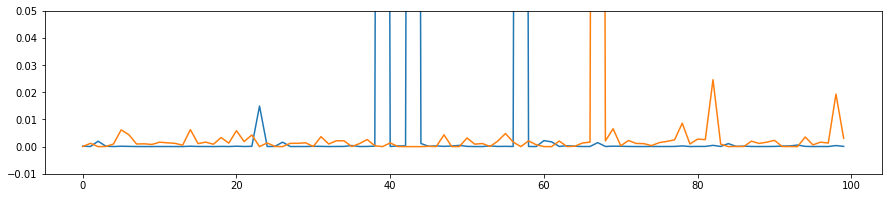

In [26]:
plt.figure(figsize=(15,3))
plt.plot(model.j_probs[1, 0, :100, 1])
plt.plot(model.theta_probs[1, 0, :100, 1])
plt.ylim(-0.01, 0.05)
plt.show()

torch.Size([1166, 14, 14])


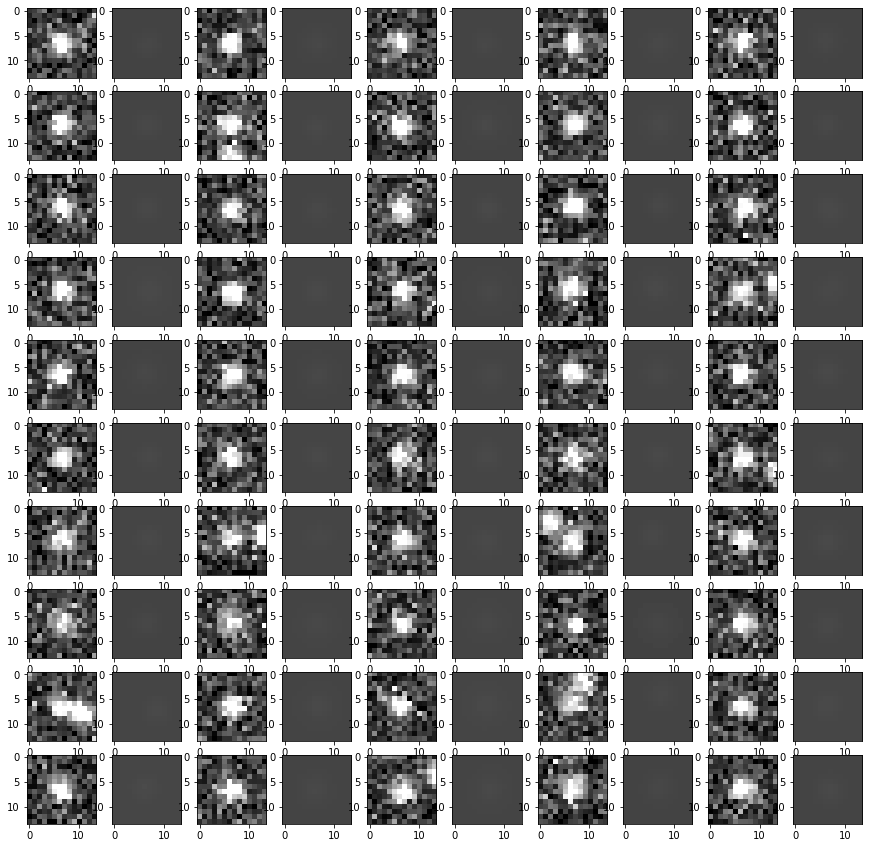

In [13]:
# spots missed by cosmos
#mask = ((~model.data.labels["z"] & (model.predictions["z_prob"] > 0.5)))
mask = ((model.data.labels["z"] ))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(50, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]],
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
plt.show()

In [14]:
param("d/h_loc").data[:, n[i], f[i]]

tensor([46.9374, 21.7005])

In [15]:
param("d/y_mode").data[:, n[i], f[i]]

tensor([0.1597, 0.7187])

In [25]:
gaussians.shape

torch.Size([14, 14])

In [21]:
mask = ((model.data.labels["z"] & ~model.predictions["z"]))

In [ ]:
n, f = np.nonzero(mask)

# spots missed by both cosmos and spotpicker
mask = ((model.data.labels["z"] & ~model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]],
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.imshow(ideal.numpy(), cmap="gray")
plt.show()

In [6]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

tensor([[1.2615e-07, 1.0000e+00],
        [1.2089e-07, 1.0000e+00]])

In [113]:
def naive(S, K):
    return (S+2)**K

def smart(S, K):
    return 2**K + S*K*2**(K-1)

def junk(S, K):
    return (S+1)**K

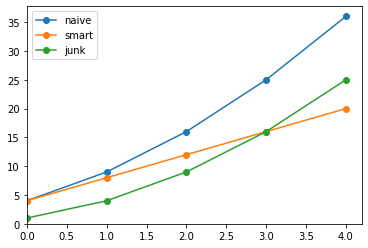

In [119]:
x = np.arange(0,5)
k = 2
plt.plot(x, naive(x,k), "o-", label="naive")
plt.plot(x, smart(x,k), "o-", label="smart")
plt.plot(x, junk(x,k), "o-", label="junk")
plt.xlim(0,)
plt.ylim(0,)
plt.legend()

In [121]:
x

array([0, 1, 2, 3, 4])

In [120]:
junk(x,k)

array([ 1,  4,  9, 16, 25])

In [122]:
smart(x,k)

array([ 4,  8, 12, 16, 20])